In [2]:
import text2dictionary as t2d
import graphmethods as gr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import LabelEncoder

# Project Notebook

## **Graph Neural Network for Recommendation System**
Based on dataset of Amazon co-purchased products 

Heidi Carolina Martinsaari, Maris Häusler

### **Extract the data**

Source of the data:

In [2]:
#!wget https://snap.stanford.edu/data/bigdata/amazon/amazon-meta.txt.gz

In [3]:
filename = "amazon-meta.txt"

The data was collected by crawling Amazon website and contains product metadata and review information about 548,552 different products (Books, music CDs, DVDs and VHS video tapes).

For each product the following information is available:

- Title
- Salesrank
- List of similar products (that get co-purchased with the current product)
- Detailed product categorization
- Product reviews: time, customer, rating, number of votes, number of people that found the review helpful

The data was collected in summer 2006.

In [4]:
!head -20 amazon-meta.txt

# Full information about Amazon Share the Love products
Total items: 548552

Id:   0
ASIN: 0771044445
  discontinued product

Id:   1
ASIN: 0827229534
  title: Patterns of Preaching: A Sermon Sampler
  group: Book
  salesrank: 396585
  similar: 5  0804215715  156101074X  0687023955  0687074231  082721619X
  categories: 2
   |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Preaching[12368]
   |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Sermons[12370]
  reviews: total: 2  downloaded: 2  avg rating: 5
    2000-7-28  cutomer: A2JW67OY8U6HHK  rating: 5  votes:  10  helpful:   9
    2003-12-14  cutomer: A2VE83MZF98ITY  rating: 5  votes:   6  helpful:   5



Collecting data with handmade function from text file to dictionary:

In [5]:
collection = t2d.collect_objects(filename)

Converting the dictionary to pandas dataframe:

In [6]:
df = pd.DataFrame(data=collection[2:])
df.head()

,Id,ASIN,title,group,salesrank,no_sim,similar,categories,catlists,reviews,revdicts
0,1,0827229534,Patterns of Preaching: A Sermon Sampler,Book,396585,5,"[0804215715, 156101074X, 0687023955, 068707423...",2,"[[Books[283155], Subjects[1000], Religion & Sp...","{'total': 2.0, 'downloaded': 2.0, 'avg rating'...","[{'date': '2000-7-28', 'customer': 'A2JW67OY8U..."
1,2,0738700797,Candlemas: Feast of Flames,Book,168596,5,"[0738700827, 1567184960, 1567182836, 073870052...",2,"[[Books[283155], Subjects[1000], Religion & Sp...","{'total': 12.0, 'downloaded': 12.0, 'avg ratin...","[{'date': '2001-12-16', 'customer': 'A11NCO6YT..."
2,3,0486287785,World War II Allied Fighter Planes Trading Cards,Book,1270652,0,[],1,"[[Books[283155], Subjects[1000], Home & Garden...","{'total': 1.0, 'downloaded': 1.0, 'avg rating'...","[{'date': '2003-7-10', 'customer': 'A3IDGASRQA..."
3,4,0842328327,Life Application Bible Commentary: 1 and 2 Tim...,Book,631289,5,"[0842328130, 0830818138, 0842330313, 084232861...",5,"[[Books[283155], Subjects[1000], Religion & Sp...","{'total': 1.0, 'downloaded': 1.0, 'avg rating'...","[{'date': '2004-8-19', 'customer': 'A2591BUPXC..."
4,5,1577943082,Prayers That Avail Much for Business: Executive,Book,455160,5,"[157794349X, 0892749504, 1577941829, 089274956...",2,"[[Books[283155], Subjects[1000], Religion & Sp...","{'total': 0.0, 'downloaded': 0.0, 'avg rating'...",[]


We can see that columns 'similar', 'catlists' and 'reviews' need to be exploded and cleaned:

In [7]:
pd.DataFrame(df.catlists.explode())["catlists"].apply(lambda x: len(str(x).split(","))).max()

13

### **Transform the data**

#### Table **df_main**:

In [8]:
normrev = pd.json_normalize(df['reviews']) # 'total', 'downloaded' and 'avg rating' are first level data 
df_main = df[['Id','ASIN','title','group','salesrank','no_sim','categories']]
df_main = df_main.join(normrev)
df_main["salesrank"] = df_main["salesrank"].fillna(0).replace("",0)
df_main["no_sim"] = df_main["no_sim"].fillna(0).replace("",0)
df_main["categories"] = df_main["categories"].fillna(0).replace("",0)
df_main["total"] = df_main["total"].fillna(0)
df_main["downloaded"] = df_main["downloaded"].fillna(0)
df_main["salesrank"] = df_main["salesrank"].astype(int)
df_main["no_sim"] = df_main["no_sim"].astype(int)
df_main["categories"] = df_main["categories"].astype(int)
df_main['total'] = df_main['total'].astype(int)
df_main['downloaded'] = df_main['downloaded'].astype(int)
df_main.columns = ["Id","ASIN","Title","Group","Salesrank","NbrOfSimilar","NbrOfCategories","TotalReviews","Downloaded","AvgRating"]
df_main.head()

,Id,ASIN,Title,Group,Salesrank,NbrOfSimilar,NbrOfCategories,TotalReviews,Downloaded,AvgRating
0,1,0827229534,Patterns of Preaching: A Sermon Sampler,Book,396585,5,2,2,2,5.0
1,2,0738700797,Candlemas: Feast of Flames,Book,168596,5,2,12,12,4.5
2,3,0486287785,World War II Allied Fighter Planes Trading Cards,Book,1270652,0,1,1,1,5.0
3,4,0842328327,Life Application Bible Commentary: 1 and 2 Tim...,Book,631289,5,5,1,1,4.0
4,5,1577943082,Prayers That Avail Much for Business: Executive,Book,455160,5,2,0,0,0.0


In [9]:
df_main.to_csv('data/main.csv',index=False)

#### Table **df_reviews**:

In [10]:
df_reviews = df[['Id','ASIN','revdicts']]
rev_explode = pd.DataFrame(df_reviews.apply(lambda row: row['revdicts'],axis=1).explode(),columns=["reviews"])
df_reviews = df_reviews.join(rev_explode)
df_rev = df_reviews.join(pd.json_normalize(df_reviews["reviews"]))
df_rev = df_rev[['Id','ASIN','date','customer','rating','votes','helpful']]
df_rev["votes"] = df_rev["votes"].fillna(0)
df_rev["helpful"] = df_rev["helpful"].fillna(0)
df_rev["votes"] = df_rev["votes"].astype(int)
df_rev["helpful"] = df_rev["helpful"].astype(int)
df_rev['date'] = pd.to_datetime(df_rev['date'], infer_datetime_format=True)
df_rev.columns = ["Id","ASIN","Date","Customer","Rating","Votes","Helpful"]
df_rev.head()

,Id,ASIN,Date,Customer,Rating,Votes,Helpful
0,1,0827229534,2000-07-28,A2JW67OY8U6HHK,5.0,10,9
0,1,0827229534,2000-07-28,A2JW67OY8U6HHK,5.0,10,9
1,2,0738700797,2003-12-14,A2VE83MZF98ITY,5.0,6,5
1,2,0738700797,2003-12-14,A2VE83MZF98ITY,5.0,6,5
1,2,0738700797,2003-12-14,A2VE83MZF98ITY,5.0,6,5


In [11]:
df_rev.to_csv('data/reviews.csv',index=False)

#### Table **df_categories**:

In [12]:
df_categories = df[['Id','ASIN','catlists']]
df_cat = pd.DataFrame(df_categories.apply(lambda row: row["catlists"],axis=1).explode(),columns=["levels"])
df_cat["levels2"] = df_cat.apply(lambda row: str(row["levels"])[1:-1],axis=1)
df_cat["L1"] = df_cat.apply(lambda row: row["levels2"].split(",")[0].replace("'","") if len(row["levels2"].split(","))>0 else "",axis=1)
df_cat["L2"] = df_cat.apply(lambda row: row["levels2"].split(",")[1].replace("'","") if len(row["levels2"].split(","))>1 else "",axis=1)
df_cat["L3"] = df_cat.apply(lambda row: row["levels2"].split(",")[2].replace("'","") if len(row["levels2"].split(","))>2 else "",axis=1)
df_cat["L4"] = df_cat.apply(lambda row: row["levels2"].split(",")[3].replace("'","") if len(row["levels2"].split(","))>3 else "",axis=1)
# for i in range(13):
#     df_cat[f"L{i+1}"] = df_cat.apply(lambda row: row["levels2"].split(",")[i].replace("'","") if len(row["levels2"].split(","))>i else np.nan,axis=1)
df_cat.drop(["levels","levels2"],axis=1,inplace=True)
df_cat = df_categories.join(df_cat)
# df_cat.drop("catlists",axis=1,inplace=True)
df_cat = df_cat[['Id','ASIN','L1','L2','L3','L4']]
df_cat.head()

,Id,ASIN,L1,L2,L3,L4
0,1,0827229534,Books[283155],Subjects[1000],Religion & Spirituality[22],Christianity[12290]
0,1,0827229534,Books[283155],Subjects[1000],Religion & Spirituality[22],Christianity[12290]
1,2,0738700797,Books[283155],Subjects[1000],Religion & Spirituality[22],Earth-Based Religions[12472]
1,2,0738700797,Books[283155],Subjects[1000],Religion & Spirituality[22],Earth-Based Religions[12472]
2,3,0486287785,Books[283155],Subjects[1000],Home & Garden[48],Crafts & Hobbies[5126]


In [ ]:
df_cat = df_cat[df_cat.L1!="a"]
Category = df_cat.apply(
    lambda row: str(row["L1"])+str(row["L2"])+str(row["L3"])+str(row["L4"]),axis=1)

enc = LabelEncoder()

CatId = pd.DataFrame(enc.fit_transform(Category),columns=["CatId"],index=df_cat.index)

df_cat = pd.concat([df_cat,CatId],axis=1)

In [13]:
df_cat.to_csv('data/categories.csv',index=False)

#### Table **df_similar**:

In [14]:
df_similar = df[['Id','ASIN','similar']]
sim_explode = df_similar.apply(lambda row:
    str(row['similar']).replace("[","").replace("]","").split(","), axis=1).explode()
df_sim = df_similar.join(pd.DataFrame(sim_explode,columns=['Similar']))
df_sim.drop("similar",axis=1,inplace=True)
df_sim['Similar'] = df_sim['Similar'].apply(lambda x: str(x).replace("'",""))
df_sim.head()

,Id,ASIN,Similar
0,1,0827229534,0804215715
0,1,0827229534,156101074X
0,1,0827229534,0687023955
0,1,0827229534,0687074231
0,1,0827229534,082721619X


In [15]:
df_sim.to_csv('data/similars.csv',index=False)

### **Analyse the data**

When starting from this section, load the data to DataFrames:

In [16]:
# df_main = pd.read_csv('data/main.csv')
# df_cat = pd.read_csv('data/categories.csv')
# df_sim = pd.read_csv('data/similars.csv')
# df_rev = pd.read_csv('data/reviews.csv')

#### **df_main**:

In [17]:
df_main.head()

,Id,ASIN,Title,Group,Salesrank,NbrOfSimilar,NbrOfCategories,TotalReviews,Downloaded,AvgRating
0,1,0827229534,Patterns of Preaching: A Sermon Sampler,Book,396585,5,2,2,2,5.0
1,2,0738700797,Candlemas: Feast of Flames,Book,168596,5,2,12,12,4.5
2,3,0486287785,World War II Allied Fighter Planes Trading Cards,Book,1270652,0,1,1,1,5.0
3,4,0842328327,Life Application Bible Commentary: 1 and 2 Tim...,Book,631289,5,5,1,1,4.0
4,5,1577943082,Prayers That Avail Much for Business: Executive,Book,455160,5,2,0,0,0.0


In [18]:
df_main.dtypes

Id                   int64
ASIN                object
Title               object
Group               object
Salesrank            int64
NbrOfSimilar         int64
NbrOfCategories      int64
TotalReviews         int64
Downloaded           int64
AvgRating          float64
dtype: object

In [19]:
df_main.groupby("Group")['Id'].count()

Group
                  5867
Baby Product         1
Book            393561
CE                   4
DVD              19828
Music           103144
Software             5
Sports               1
Toy                  8
Video            26131
Video Games          1
Name: Id, dtype: int64

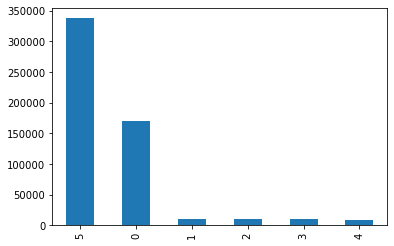

In [20]:
df_main.NbrOfSimilar.value_counts().plot(kind="bar")
plt.show()

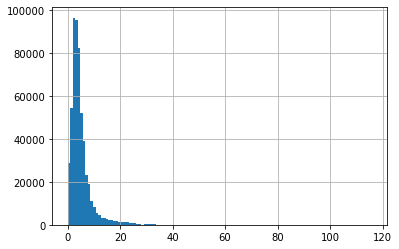

In [21]:
df_main["NbrOfCategories"].hist(bins=120)
plt.show()

In [22]:
df_main.describe()

,Id,Salesrank,NbrOfSimilar,NbrOfCategories,TotalReviews,Downloaded,AvgRating
count,548551.000000,5.485510e+05,548551.000000,548551.000000,548551.000000,548551.000000,542684.000000
mean,274276.000000,4.840907e+05,3.260818,4.575143,14.186448,13.842367,3.209534
std,158353.178094,5.669177e+05,2.300150,4.452269,74.382080,71.537312,1.996296
min,1.000000,-1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,137138.500000,8.573300e+04,0.000000,2.000000,0.000000,0.000000,0.000000
50%,274276.000000,2.942890e+05,5.000000,3.000000,2.000000,2.000000,4.000000
75%,411413.500000,6.659595e+05,5.000000,6.000000,8.000000,7.000000,5.000000
max,548551.000000,3.798351e+06,5.000000,116.000000,5545.000000,4995.000000,5.000000


#### for graph:

Based on what we have seen:
- We keep only Books, Music, DVD and Videos

We make analysis again:

In [23]:
df_main.Group.unique()

array(['Book', 'Music', 'DVD', 'Video', '', 'Toy', 'Video Games',
       'Software', 'Baby Product', 'CE', 'Sports'], dtype=object)

In [24]:
data = df_main[df_main.Group.isin(["Book","Music","DVD","Video"])]
data.shape

(542664, 10)

In [25]:
data.to_csv("data/nodes.csv",index=False)

#### **df_cat**:

In [26]:
df_cat.head()

,Id,ASIN,L1,L2,L3,L4
0,1,0827229534,Books[283155],Subjects[1000],Religion & Spirituality[22],Christianity[12290]
0,1,0827229534,Books[283155],Subjects[1000],Religion & Spirituality[22],Christianity[12290]
1,2,0738700797,Books[283155],Subjects[1000],Religion & Spirituality[22],Earth-Based Religions[12472]
1,2,0738700797,Books[283155],Subjects[1000],Religion & Spirituality[22],Earth-Based Religions[12472]
2,3,0486287785,Books[283155],Subjects[1000],Home & Garden[48],Crafts & Hobbies[5126]


In [27]:
df_cat.isnull().sum()

Id      0
ASIN    0
L1      0
L2      0
L3      0
L4      0
dtype: int64

In [28]:
df_cat.nunique()

Id      548551
ASIN    548551
L1          16
L2          38
L3         168
L4        1206
dtype: int64

In [29]:
df_cat.L1.unique()

array(['Books[283155]', '[172282]', 'Music[5174]', '[265523]', '[139452]',
       'a', '[540744]', '[468642]', '[229534]', '[229220]', '[171280]',
       '[700060]', '[1055398]', 'Sports & Outdoor[3375251]',
       'Sportsrus.com[3489201]', '[1064952]'], dtype=object)

In [30]:
df_cat = df_cat[df_cat.Id.isin(data.Id.values)]

In [31]:
df_cat.nunique()

Id      542664
ASIN    542664
L1          14
L2          33
L3         153
L4        1175
dtype: int64

In [32]:
df_cat.L1.unique()

array(['Books[283155]', '[172282]', 'Music[5174]', '[265523]', '[139452]',
       'a', '[540744]', '[468642]', '[229534]', '[229220]', '[700060]',
       '[1055398]', '[171280]', '[1064952]'], dtype=object)

In [33]:
df_cat[df_cat.L1=='a'].isnull().sum(), df_cat[df_cat.L1=='a'].shape

(Id      0
 ASIN    0
 L1      0
 L2      0
 L3      0
 L4      0
 dtype: int64,
 (22903, 6))

These values are actually empty values, we will drop them:

In [34]:
df_cat = df_cat[df_cat.L1!='a']
df_cat.isnull().sum()

Id      0
ASIN    0
L1      0
L2      0
L3      0
L4      0
dtype: int64

In [35]:
df_cat[df_cat.L3.isnull()]

,Id,ASIN,L1,L2,L3,L4


In [36]:
df_cat.nunique()

Id      519761
ASIN    519761
L1          13
L2          32
L3         153
L4        1175
dtype: int64

In [37]:
df_cat.L2.unique()

array([' Subjects[1000]', ' Categories[493964]', ' Styles[301668]',
       ' Specialty Stores[468040]', ' Specialty Stores[504360]',
       ' Amazon.com Stores[285080]', ' DVD[130]', ' Formats[504358]',
       ' VHS[404272]', ' Categories[540988]', ' Specialty Stores[547930]',
       ' Labels[892976]', ' By Publisher[298531]', ' Formats[468038]',
       ' Specialty Stores[471282]', ' Specialty Stores[509348]',
       ' Special Features[301756]', ' Our Favorites[510958]',
       ' Brands[409488]', ' New Categories[13458191]',
       ' Categories[712210]', ' Categories[1063498]',
       ' Specialty Stores[491294]', ' Brands[171457]',
       ' Favorite Characters[194007]', ' Electronics Features[13900851]',
       ' Specialty Stores[769106]', ' Categories[491290]',
       ' Categories[491286]', ' Brands[540996]',
       ' Camera & Photo Features[13900861]', ' Categories[1084654]'],
      dtype=object)

In [38]:
df_cat.groupby(["L1","L2","L3"]).count().to_excel('statistics.xls')

/var/folders/hk/kbn1q_sj4jz4lh0m7x05vff80000gn/T/ipykernel_7124/4248942510.py:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  df_cat.groupby(["L1","L2","L3"]).count().to_excel('statistics.xls')


#### **df_sim**:

From the df_sim we can get the links between nodes:

In [39]:
df_sim.head()

,Id,ASIN,Similar
0,1,0827229534,0804215715
0,1,0827229534,156101074X
0,1,0827229534,0687023955
0,1,0827229534,0687074231
0,1,0827229534,082721619X


In [40]:
df_sim.shape

(1958183, 3)

#### for graph:

Let's represent the node with Id's:

In [41]:
df1 = df_sim.set_index('Similar')
df2 = data.set_index('ASIN')
df3 = df1.join(df2,rsuffix='_2',how='inner') # Id_2 only from data
df3 = df3[df3.Id.isin(data.Id.values)] # Id only from data
df3.head()

,Id,ASIN,Id_2,Title,Group,Salesrank,NbrOfSimilar,NbrOfCategories,TotalReviews,Downloaded,AvgRating
0001515195,185002,0005310075,96102,Go to the Ant,Book,770150,4,0,0,0,0.0
0002154129,275265,0002154463,299097,France the Beautiful Cookbook,Book,76171,5,4,4,4,5.0
0002154129,309702,0002551543,299097,France the Beautiful Cookbook,Book,76171,5,4,4,4,5.0
0002154463,178882,0002550326,275265,Italy : The Beautiful Cookbook (Beautiful Cook...,Book,34654,5,2,3,3,4.0
0002154463,299097,0002154129,275265,Italy : The Beautiful Cookbook (Beautiful Cook...,Book,34654,5,2,3,3,4.0


In [42]:
alinks = df3[['Id','Id_2']].reset_index(drop=True)
#links2 = df3[['Id_2','Id']].reset_index(drop=True)
#links = links1.append(links2)
alinks.drop_duplicates(inplace=True)
alinks.columns = ["source","target"]
alinks.shape

(275230, 2)

In [43]:
alinks.head()

,from,to
0,185002,96102
1,275265,299097
2,309702,299097
3,178882,275265
4,299097,275265


In [44]:
alinks.to_csv('data/links.csv',index=False)

Create types for edges/links:

In [45]:
df1 = alinks.set_index("from")
df3 = data.set_index("Id")
df1_attr = df1.join(df3)
df1_attr = df1_attr[["to","Group"]]
df2_attr = df1_attr.reset_index().set_index("to")
df2_attr.columns = ["from","fromGr"]
df2 = df2_attr.join(df3)
df2 = df2[["from","fromGr","Group"]]
df2 = df2.reset_index()
df2.columns = ["to","from","fromGr","toGr"]
df_links = df2[["from","to","fromGr","toGr"]]
df_links["connection"] = df_links.apply(lambda row: str(row["fromGr"])+str(row["toGr"]), axis=1)
df_links = df_links[["from","to","connection"]]
df_links.head()

/var/folders/hk/kbn1q_sj4jz4lh0m7x05vff80000gn/T/ipykernel_7124/842213600.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_links["connection"] = df_links.apply(lambda row: str(row["fromGr"])+str(row["toGr"]), axis=1)


,from,to,connection
0,500600,1,BookBook
1,454888,2,BookBook
2,355935,7,MusicMusic
3,55461,8,BookBook
4,445607,8,BookBook


In [46]:
types = {'BookBook': 'BookBook', 'MusicMusic': 'MusicMusic', 'DVDDVD': 'DVDDVD', 'VideoVideo': 'VideoVideo',
         'BookVideo': 'BookVideo', 
         'VideoBook': 'BookVideo', 
         'BookDVD': 'BookDVD', 
         'DVDBook': 'BookDVD',
         'BookMusic': 'BookMusic', 
         'MusicBook': 'BookMusic', 
         'MusicDVD': 'MusicDVD', 
         'DVDMusic': 'MusicDVD',
         'MusicVideo': 'MusicVideo', 
         'VideoMusic': 'MusicVideo', 
         'DVDVideo': 'DVDVideo',
         'VideoDVD': 'DVDVideo'}

In [47]:
df_links["conn_type"] = df_links["connection"].apply(lambda x: types[x])

In [48]:
df_links = df_links[["from","to","conn_type"]]

In [49]:
df_links.groupby("conn_type").count()

,from,to
conn_type,,
BookBook,202903,202903
BookDVD,540,540
BookMusic,326,326
BookVideo,452,452
DVDDVD,11755,11755
DVDVideo,7070,7070
MusicDVD,793,793
MusicMusic,45755,45755
MusicVideo,165,165


In [50]:
df_links.to_csv("data/links_type.csv",index=False)

#### **df_rev**:

In [51]:
df_rev.head()

,Id,ASIN,Date,Customer,Rating,Votes,Helpful
0,1,0827229534,2000-07-28,A2JW67OY8U6HHK,5.0,10,9
0,1,0827229534,2000-07-28,A2JW67OY8U6HHK,5.0,10,9
1,2,0738700797,2003-12-14,A2VE83MZF98ITY,5.0,6,5
1,2,0738700797,2003-12-14,A2VE83MZF98ITY,5.0,6,5
1,2,0738700797,2003-12-14,A2VE83MZF98ITY,5.0,6,5


In [52]:
df_rev.Customer.nunique()

270201

#### for graph:

In [53]:
cust_enc = LabelEncoder()

df_rev["CId"] = cust_enc.fit_transform(df_rev["Customer"])
df_rev.head()

,Id,ASIN,Date,Customer,Rating,Votes,Helpful,CId
0,1,0827229534,2000-07-28,A2JW67OY8U6HHK,5.0,10,9,110643
0,1,0827229534,2000-07-28,A2JW67OY8U6HHK,5.0,10,9,110643
1,2,0738700797,2003-12-14,A2VE83MZF98ITY,5.0,6,5,133242
1,2,0738700797,2003-12-14,A2VE83MZF98ITY,5.0,6,5,133242
1,2,0738700797,2003-12-14,A2VE83MZF98ITY,5.0,6,5,133242


In [87]:
df_rev["CId"] = df_rev["CId"].apply(lambda x: "C"+str(x)) # for the sake of different Id-s of customers and products

In [88]:
bilinks_time = df_rev[['Id','CId','Date','Rating']]
bilinks_time.head()

,Id,CId,Date,Rating
0,1,C110643,2000-07-28,5.0
0,1,C110643,2000-07-28,5.0
1,2,C133242,2003-12-14,5.0
1,2,C133242,2003-12-14,5.0
1,2,C133242,2003-12-14,5.0


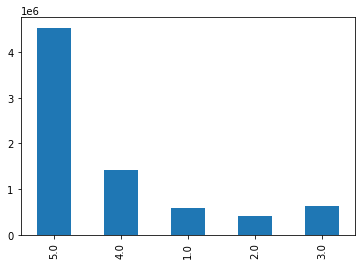

In [89]:
bilinks_time.Rating.value_counts(sort=False).plot(kind="bar")
plt.show()

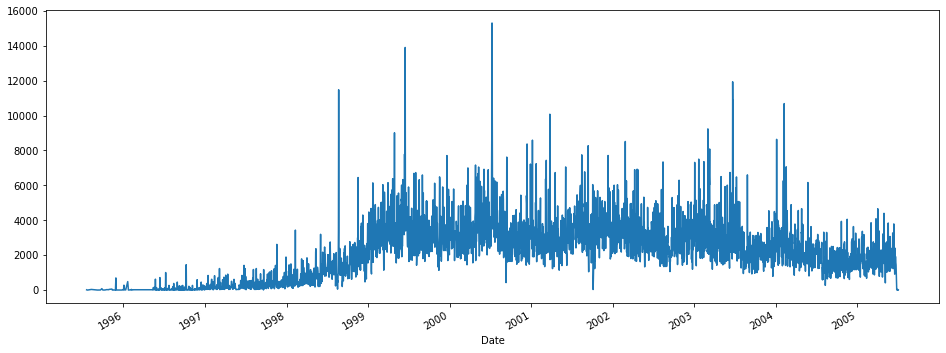

In [90]:
plt.figure(figsize=(16,6))
bilinks_time.groupby("Date")['Id'].count().plot(kind="line")
plt.show()

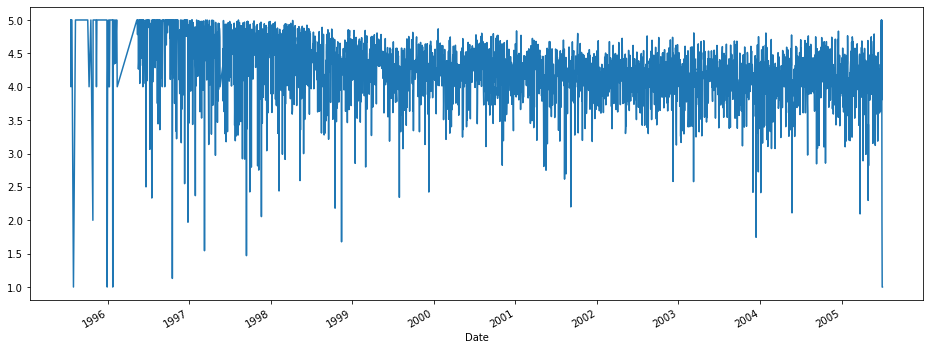

In [91]:
plt.figure(figsize=(16,6))
bilinks_time.groupby("Date")['Rating'].mean().plot(kind="line")
plt.show()

In [92]:
bilinks_time.shape

(7739071, 4)

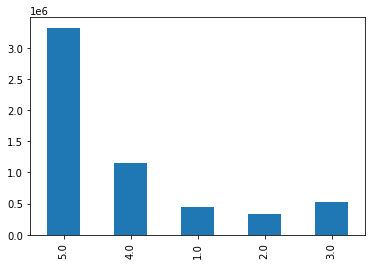

In [93]:
newer_bilinks = bilinks_time[bilinks_time.Date>='2000-01-01']
newer_bilinks.Rating.value_counts(sort=False).plot(kind="bar")
plt.show()

In [94]:
bilinks = pd.DataFrame(newer_bilinks.groupby(["Id","CId"])["Rating"].mean()).reset_index()
bilinks.shape

(410480, 3)

In [95]:
bilinks.to_csv("data/bilinks.csv",index=False)

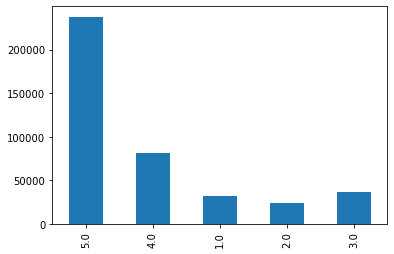

In [96]:
bilinks.Rating.value_counts(sort=False).plot(kind="bar")
plt.show()

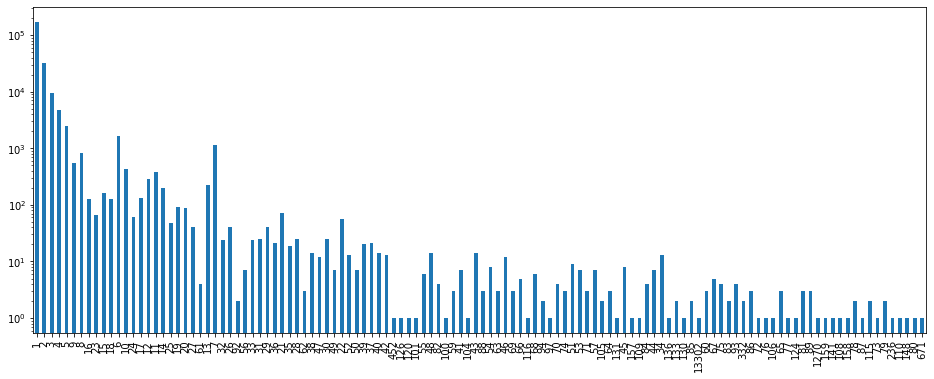

In [97]:
plt.figure(figsize=(16,6))
bilinks.groupby("CId")['Id'].count().value_counts(sort=False).plot(kind="bar")
plt.yscale("log")
plt.xticks()
plt.show()

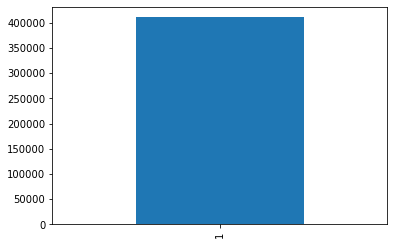

In [98]:
bilinks.groupby("Id")['CId'].count().value_counts().plot(kind="bar")
plt.show()

#### more for graph:
Customer relation links between products

In [3]:
bilinks = pd.read_csv("data/bilinks.csv")
nodes = pd.read_csv("data/nodes.csv")

In [4]:
""" Also as function in preprocessor.py """
# only the best ratings are considered for recommendation:
good_ratings = bilinks[bilinks.Rating>4]
print("Good ratings: ", good_ratings.shape)

# join the products through THE SAME CUSTOMER:
one = good_ratings.set_index("CId")
two = good_ratings.set_index("CId")
all_links = one.join(two,lsuffix="_1",rsuffix="_2")
diff_nodes = all_links[all_links.Id_1 != all_links.Id_2]
print("Nbr of links: ", diff_nodes.shape)

# select only the source and target node id columns:
clinks = diff_nodes[["Id_1","Id_2"]]
clinks.drop_duplicates(inplace=True)
clinks.reset_index(drop=True,inplace=True)
print("Nbr of links after dupl removed: ", clinks.shape)

# Check that all nodes exists in nodes
clinks = clinks[(clinks["Id_1"].isin(nodes.index)) & 
                (clinks["Id_2"].isin(nodes.index))]

# show:
clinks.columns = ["source","target"]
clinks.head()

Good ratings:  (237756, 3)
Nbr of links:  (71680770, 4)
Nbr of links after dupl removed:  (71680770, 2)


/var/folders/hk/kbn1q_sj4jz4lh0m7x05vff80000gn/T/ipykernel_14962/146860781.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_links.drop_duplicates(inplace=True)


,source,target
0,154695,234721
1,234721,154695
2,338609,478139
3,478139,338609
4,462849,462850
